In [1]:
# import yfinance as yf
# import pandas as pd

# # Download NVDA stock data at 5-minute intervals for the past 30 days
# df = yf.download(tickers='NVDA', period='30d', interval='5m')

# # Flatten columns if multi-indexed
# if isinstance(df.columns, pd.MultiIndex):
#     df.columns = df.columns.get_level_values(0)

# # Convert index (Datetime) from UTC to US/Eastern
# df.index = df.index.tz_convert('US/Eastern')

# # Preview the DataFrame
# print(df.head())

# # Optional: Save to CSV
# df.to_csv('nvda_30days_5min_20_June.csv')

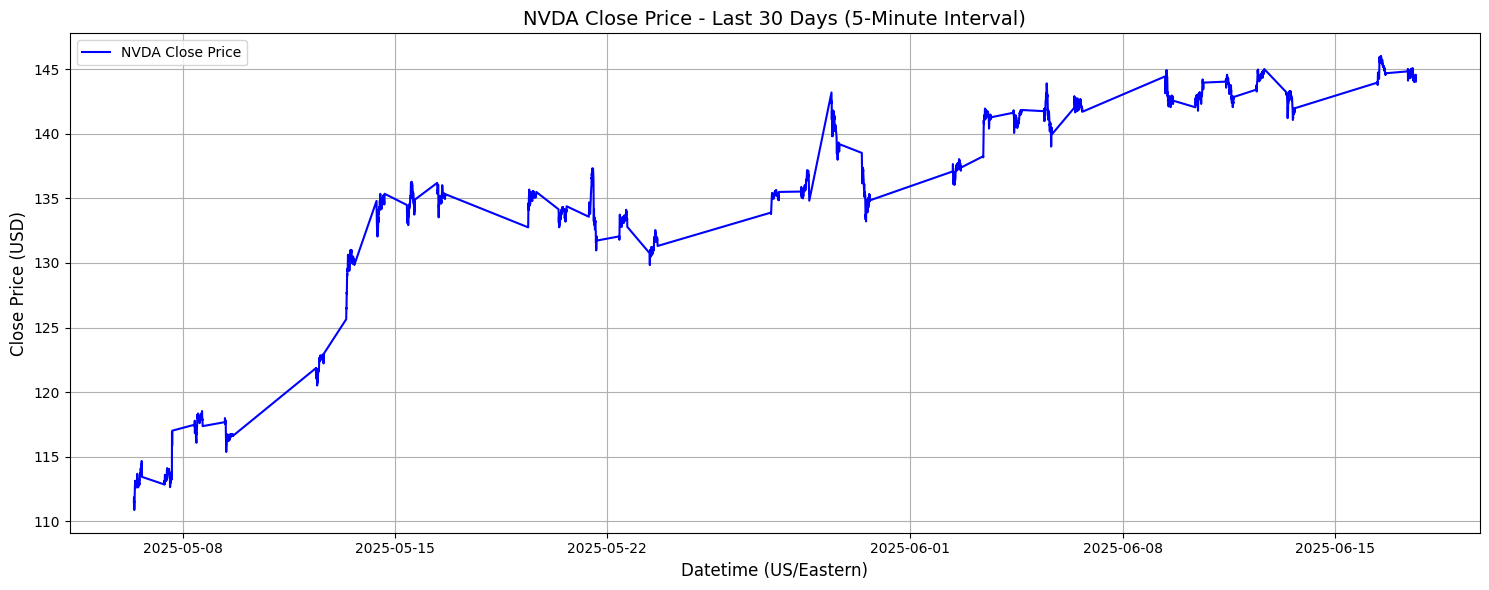

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV and parse the datetime column
df = pd.read_csv('nvda_30days_5min.csv', parse_dates=['Datetime'], index_col='Datetime')

# Plot Datetime vs Close
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], label='NVDA Close Price', color='blue')
plt.title('NVDA Close Price - Last 30 Days (5-Minute Interval)', fontsize=14)
plt.xlabel('Datetime (US/Eastern)', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/10, Loss: 0.029162
Epoch 2/10, Loss: 0.022508
Epoch 3/10, Loss: 0.009845
Epoch 4/10, Loss: 0.007721
Epoch 5/10, Loss: 0.003997
Epoch 6/10, Loss: 0.004035
Epoch 7/10, Loss: 0.003766
Epoch 8/10, Loss: 0.003132
Epoch 9/10, Loss: 0.003251
Epoch 10/10, Loss: 0.002959


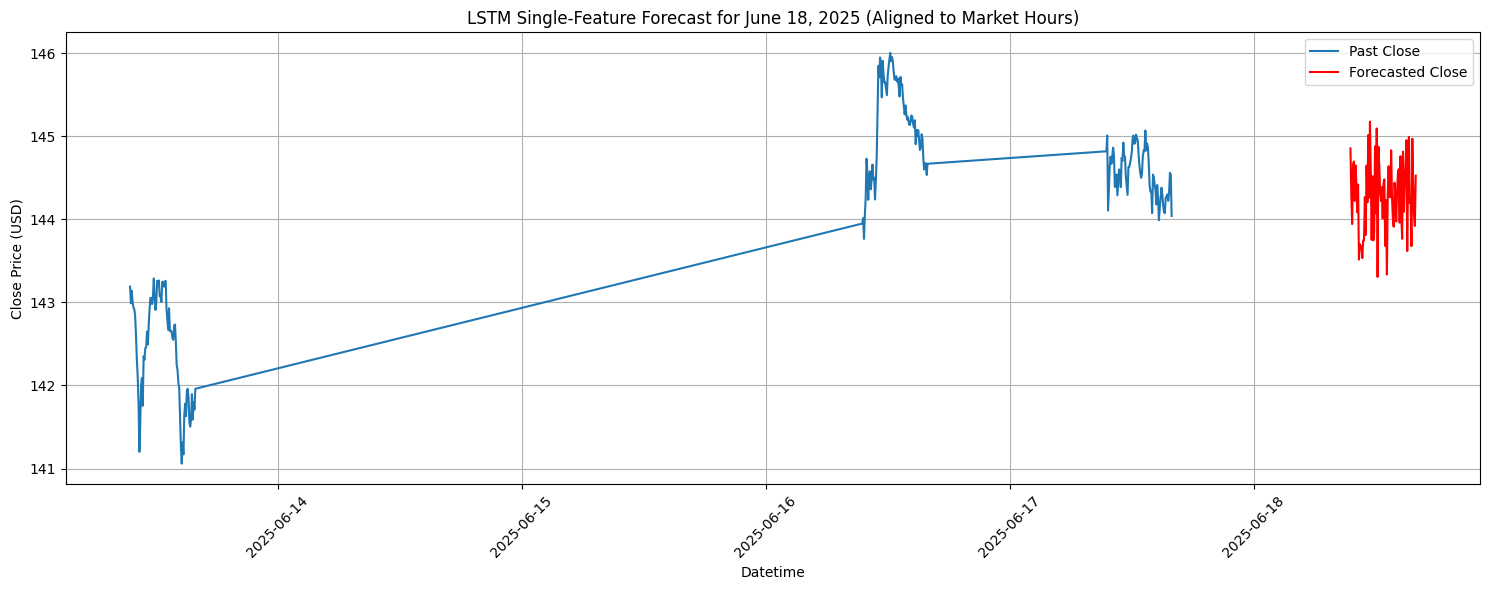

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

# -------------------------------------
# Step 1: Load and preprocess the data
# -------------------------------------
df = pd.read_csv("nvda_30days_5min.csv", parse_dates=['Datetime'], index_col='Datetime')

# Use only Close price
close_prices = df['Close'].values.reshape(-1, 1)

# Normalize close prices
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# -------------------------------------
# Step 2: Prepare sequences
# -------------------------------------
INPUT_LEN = 78 * 3   # past 3 trading days (78 5-min intervals per day)
OUTPUT_LEN = 78      # forecast next 1 trading day (5-minute steps)

X = []
Y = []

for i in range(len(scaled_close) - INPUT_LEN - OUTPUT_LEN):
    X.append(scaled_close[i:i+INPUT_LEN])
    Y.append(scaled_close[i+INPUT_LEN:i+INPUT_LEN+OUTPUT_LEN])

X = np.array(X)  # shape (N, INPUT_LEN, 1)
Y = np.array(Y).squeeze(-1)  # shape (N, OUTPUT_LEN)

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# -------------------------------------
# Step 3: Define the LSTM model
# -------------------------------------
class SingleFeatureLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_len=78):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = SingleFeatureLSTM()

# -------------------------------------
# Step 4: Training loop
# -------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    permutation = torch.randperm(X_tensor.size(0))
    for i in range(0, X_tensor.size(0), BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_x = X_tensor[indices]
        batch_y = Y_tensor[indices]

        output = model(batch_x)
        loss = criterion(output, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")

# -------------------------------------
# Step 5: Forecast next 78 steps
# -------------------------------------
last_input = torch.tensor(scaled_close[-INPUT_LEN:], dtype=torch.float32).unsqueeze(0)  # (1, INPUT_LEN, 1)

model.eval()
with torch.no_grad():
    forecast_scaled = model(last_input).numpy().flatten()

# Inverse transform forecast to original scale
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

past_close = close_prices[-INPUT_LEN:].flatten()

# -------------------------------------
# Step 6: Generate exact 09:30–16:00 5-min timestamps
# -------------------------------------
forecast_date = pd.Timestamp('2025-06-18')

# Manually define the market open and close time
market_open_dt = pd.Timestamp(forecast_date.date()).replace(hour=9, minute=30).tz_localize('America/New_York')
market_close_dt = pd.Timestamp(forecast_date.date()).replace(hour=16, minute=0).tz_localize('America/New_York')

# Generate all 5-minute intervals from 09:30 to 16:00
full_day_timestamps = pd.date_range(start=market_open_dt, end=market_close_dt, freq='5min', tz='America/New_York')

# Truncate to desired forecast length
future_timestamps = full_day_timestamps[:OUTPUT_LEN]

# Convert past timestamps to US/Eastern for alignment
past_timestamps = df.index[-INPUT_LEN:]
past_timestamps = past_timestamps.tz_convert('America/New_York')

# Combine past and forecast timestamps
all_timestamps = past_timestamps.append(future_timestamps)

# -------------------------------------
# Step 7: Plot
# -------------------------------------
plt.figure(figsize=(15, 6))
plt.plot(all_timestamps[:INPUT_LEN], past_close, label='Past Close')
plt.plot(all_timestamps[INPUT_LEN:], forecast, label='Forecasted Close', color='red')
plt.xlabel('Datetime')
plt.ylabel('Close Price (USD)')
plt.title(f'LSTM Single-Feature Forecast for June 18, 2025 (Aligned to Market Hours)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------
# Step 8: Save forecast
# -------------------------------------
forecast_df = pd.DataFrame({
    'Datetime': future_timestamps,
    'Forecasted_Close': forecast
})
forecast_df.to_csv("forecast_single_feature_nvda_2025_06_18.csv", index=False)

Epoch 1/10, Loss: 0.032407
Epoch 2/10, Loss: 0.012665
Epoch 3/10, Loss: 0.004755
Epoch 4/10, Loss: 0.004197
Epoch 5/10, Loss: 0.003047
Epoch 6/10, Loss: 0.003381
Epoch 7/10, Loss: 0.002855
Epoch 8/10, Loss: 0.002998
Epoch 9/10, Loss: 0.002846
Epoch 10/10, Loss: 0.002571


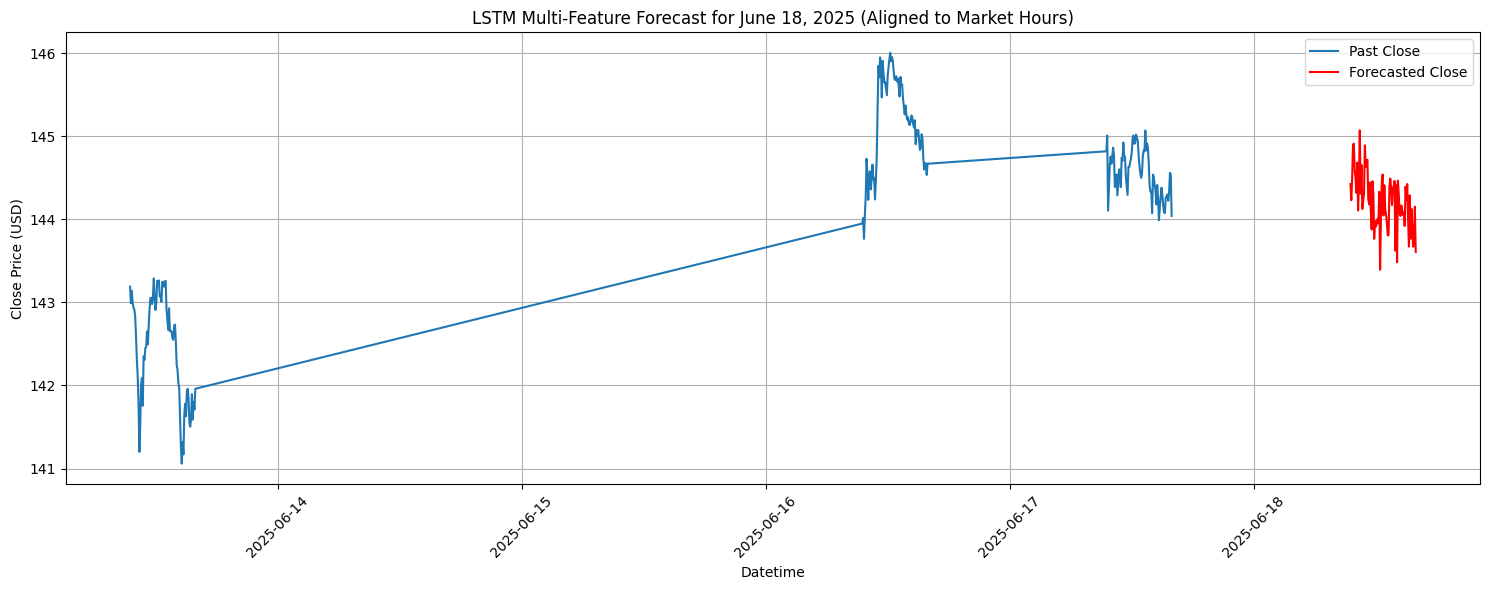

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

# -------------------------------------
# Step 1: Load and preprocess the data
# -------------------------------------
df = pd.read_csv("nvda_30days_5min.csv", parse_dates=['Datetime'], index_col='Datetime')
features = ['Close', 'High', 'Low', 'Open', 'Volume']
data = df[features].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

close_index = features.index('Close')

# -------------------------------------
# Step 2: Prepare sequences
# -------------------------------------
INPUT_LEN = 78*3   # 3 trading days (78 5-min intervals per day)
OUTPUT_LEN = 78    # 1 trading day ahead forecast

X, Y = [], []
for i in range(len(scaled_data) - INPUT_LEN - OUTPUT_LEN):
    X.append(scaled_data[i:i+INPUT_LEN])
    Y.append(scaled_data[i+INPUT_LEN:i+INPUT_LEN+OUTPUT_LEN, close_index])

X = np.array(X)
Y = np.array(Y)

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# -------------------------------------
# Step 3: Define LSTM model
# -------------------------------------
class MultiFeatureLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, output_len=78):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = MultiFeatureLSTM()

# -------------------------------------
# Step 4: Training loop
# -------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    permutation = torch.randperm(X_tensor.size(0))
    for i in range(0, X_tensor.size(0), BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_x, batch_y = X_tensor[indices], Y_tensor[indices]

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")

# -------------------------------------
# Step 5: Forecast next 78 steps
# -------------------------------------
last_input = torch.tensor(scaled_data[-INPUT_LEN:], dtype=torch.float32).unsqueeze(0)  # (1, 234, 5)

model.eval()
with torch.no_grad():
    forecast_scaled = model(last_input).numpy().flatten()

# Inverse transform only Close column using dummy array
dummy = np.zeros((forecast_scaled.shape[0], len(features)))
dummy[:, close_index] = forecast_scaled
forecast = scaler.inverse_transform(dummy)[:, close_index]

past_close = data[-INPUT_LEN:, close_index]

# -------------------------------------
# Step 6: Plot forecast aligned to June 18, 2025 market hours
# -------------------------------------
# Define forecast date
forecast_date = pd.Timestamp('2025-06-18')

# Define exact 09:30 AM to 4:00 PM market hours in US/Eastern timezone
market_open_dt = pd.Timestamp(forecast_date.date()).replace(hour=9, minute=30).tz_localize('America/New_York')
market_close_dt = pd.Timestamp(forecast_date.date()).replace(hour=16, minute=0).tz_localize('America/New_York')

# Generate 5-min intervals manually to guarantee 09:30 start
full_day_timestamps = pd.date_range(start=market_open_dt, end=market_close_dt, freq='5min', tz='America/New_York')

# Truncate to OUTPUT_LEN (typically 78 5-min bars)
future_timestamps = full_day_timestamps[:OUTPUT_LEN]

# Confirm that we have enough points
if len(future_timestamps) < OUTPUT_LEN:
    raise ValueError(f"Only {len(future_timestamps)} valid intervals, need {OUTPUT_LEN}")

# Past timestamps (convert to US/Eastern)
past_timestamps = df.index[-INPUT_LEN:]
past_timestamps = past_timestamps.tz_convert('America/New_York')

# Combine past and future timestamps
all_timestamps = past_timestamps.append(future_timestamps)

# -------------------------------------
# Step 7: Plot
# -------------------------------------
plt.figure(figsize=(15, 6))
plt.plot(all_timestamps[:INPUT_LEN], past_close, label='Past Close')
plt.plot(all_timestamps[INPUT_LEN:], forecast, label='Forecasted Close', color='red')
plt.xlabel('Datetime')
plt.ylabel('Close Price (USD)')
plt.title(f'LSTM Multi-Feature Forecast for June 18, 2025 (Aligned to Market Hours)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------
# Step 8: Save forecast
# -------------------------------------
forecast_df = pd.DataFrame({
    'Datetime': future_timestamps,
    'Forecasted_Close': forecast
})
forecast_df.to_csv("forecast_multi_features_nvda_2025_06_18.csv", index=False)